In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

2023-12-20 17:57:51.870248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 17:57:51.870287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 17:57:51.870872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 17:57:51.874625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 17:57:52.444387: W tensorflow/compiler/tf2

In [2]:
train_df = pd.read_csv("data/train.txt", delimiter=';', header=None, names=['text', 'label'])
val_df = pd.read_csv("data/val.txt", delimiter=';', header=None, names=['text', 'label'])
test_df = pd.read_csv("data/test.txt", delimiter=';', header=None, names=['text', 'label'])

train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
len(train_df), len(val_df), len(test_df)

(16000, 2000, 2000)

In [4]:
train_df["label"].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [5]:
val_df["label"].value_counts()

label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

In [6]:
test_df["label"].value_counts()

label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [7]:
from imblearn.over_sampling import RandomOverSampler


# oversample = RandomOverSampler(sampling_strategy='auto')
oversample = RandomOverSampler(sampling_strategy='minority')

# Применение Oversampling к данным
train_text, train_labels = oversample.fit_resample(train_df.drop(columns=['label']), train_df['label'])
train_labels.value_counts()

label
surprise    5362
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
Name: count, dtype: int64

In [8]:
val_text = val_df.drop("label", axis=1)
val_labels = val_df["label"]
test_text = test_df.drop("label", axis=1)
test_labels = test_df["label"]

train_text = train_text.squeeze()
val_text = val_text.squeeze()
test_text = test_text.squeeze()

# Преобразования текстовых меток классов в числовой формат
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)

In [9]:
max_words = 10000
max_len = 50
embedding_dim = 64


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)
                            
sequences = tokenizer.texts_to_sequences(train_text)
tr_x = pad_sequences(sequences, maxlen=max_len) 
tr_y = to_categorical(train_labels)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=max_len)
val_y = to_categorical(val_labels)

sequences = tokenizer.texts_to_sequences(test_text)
ts_x = pad_sequences(sequences, maxlen=max_len)
ts_y = to_categorical(test_labels)

In [10]:
epochs = 7
batch_size = 16

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(units=128, return_sequences=True)), # рекуррентный слой
    Dropout(0.3),
    Bidirectional(LSTM(units=64)),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

# model = Sequential([
#     Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
#     Bidirectional(LSTM(units=256, return_sequences=True)), 
#     Dropout(0.5), 
#     Bidirectional(LSTM(units=128, return_sequences=True)),  
#     Dropout(0.5),
#     Bidirectional(LSTM(units=64)), 
#     Dropout(0.3),  
#     BatchNormalization(),  # Добавляем слой BatchNormalization
#     Dense(units=6, activation='softmax')
# ])

# Компиляция модели с выбором оптимизатора, функции потерь и метрики
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели на обучающих данных и оценка на валидационных данных
history = model.fit(tr_x, tr_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y))

# Оценка производительности модели на тестовых данных
test_loss, test_accuracy = model.evaluate(ts_x, ts_y)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

2023-12-20 17:57:53.452382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 17:57:53.474467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 17:57:53.474520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 17:57:53.477629: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 17:57:53.477698: I external/local_xla/xla/stream_executor

Epoch 1/7


2023-12-20 17:57:57.168166: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-20 17:57:57.588125: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f76330a8020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 17:57:57.588150: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-12-20 17:57:57.591374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703077077.619271  108897 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1300/1300 [==============================] - 29s 19ms/step - loss: 1.1739 - accuracy: 0.5400 - val_loss: 1.0997 - val_accuracy: 0.5970
Epoch 2/7
1300/1300 [==============================] - 20s 16ms/step - loss: 0.4769 - accuracy: 0.8434 - val_loss: 0.3657 - val_accuracy: 0.8870
Epoch 3/7
1300/1300 [==============================] - 20s 15ms/step - loss: 0.2444 - accuracy: 0.9239 - val_loss: 0.2668 - val_accuracy: 0.9150
Epoch 4/7
1300/1300 [==============================] - 20s 15ms/step - loss: 0.1741 - accuracy: 0.9427 - val_loss: 0.2403 - val_accuracy: 0.9170
Epoch 5/7
1300/1300 [==============================] - 19s 15ms/step - loss: 0.1343 - accuracy: 0.9537 - val_loss: 0.2317 - val_accuracy: 0.9240
Epoch 6/7
1300/1300 [==============================] - 20s 15ms/step - loss: 0.1177 - accuracy: 0.9595 - val_loss: 0.2151 - val_accuracy: 0.9250
Epoch 7/7
63/63 [==============================] - 1s 8ms/step - loss: 0.2378 - accuracy: 0.9180
Test Accuracy: 91.80%
Test Loss: 0.2378


63/63 [==============================] - 0s 5ms/step


<Axes: >

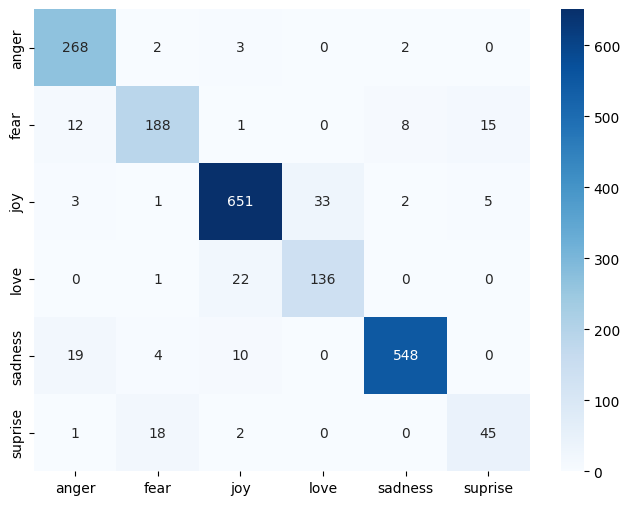

In [58]:
y_true=[]
for i in range(len(ts_y)):
    x = np.argmax(ts_y[i]) 
    y_true.append(x)
    
preds = model.predict(ts_x)
y_pred = np.argmax(preds, axis=1)

plt.figure(figsize=(8,6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5:'suprise'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [90]:
def predict(text):        
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    prediction = model.predict(x_new)[0].tolist()

    index = prediction.index(max(prediction))
    result = None
    if max(prediction) > 0.5:
        result = list(encoder.classes_)[index]

    print("Сообщение: " + text)
    if result:
        print(f" Результат: {result}")
    else:
        print("Нет результата")

predict("I feel bad")

1/1 [==============================] - 0s 14ms/step
Сообщение: I feel bad
 Результат: sadness


In [91]:
predict("I'm very surprised that you did it, how cool is it")

1/1 [==============================] - 0s 14ms/step
Сообщение: I'm very surprised that you did it, how cool is it
 Результат: joy


In [94]:
predict("I'm going to blow it all up.")

1/1 [==============================] - 0s 16ms/step


Сообщение: I'm going to blow it all up.
 Результат: anger
